# <center>USO Stock Price Prediction</center>

## <center>1. Forecasting the Price of the USO Stock using ARIMA model</center>

### Importing the required modules

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_column',None)

In [4]:
data = pd.read_csv('Datasets/FINAL_USO.xls',usecols=['Date','Close'])

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

In [6]:
data.set_index('Date',inplace=True)
data.head()

,Close
Date,
2011-12-15,152.330002
2011-12-16,155.229996
2011-12-19,154.869995
2011-12-20,156.979996
2011-12-21,157.160004


### Plotting the stock close price

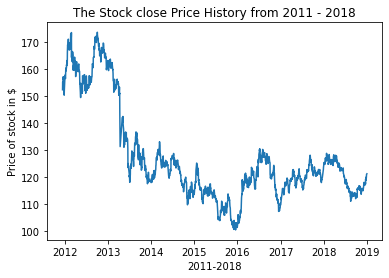

In [7]:
plt.title('The Stock close Price History from 2011 - 2018')
plt.plot(data['Close'])
plt.xlabel('2011-2018')
plt.ylabel('Price of stock in $')
plt.show()

### Testing for stationarity

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
def ad_test(d):
    a = adfuller(d)
    print('P value : ',a[1])
    print('#Lags used : ',a[2])
    print('No. of observations used : ',a[3])
    print('It is stationary we accept H0') if a[1]<=0.05 else print('It is not stationary we reject H0')

In [10]:
ad_test(data['Close'].dropna())

P value :  0.36887815382329475
#Lags used :  1
No. of observations used :  1716
It is not stationary we reject H0


### Differencing to make the data stationary

In [11]:
data['first_diff'] = data['Close'] - data['Close'].shift(1)

In [12]:
ad_test(data['first_diff'].dropna())

P value :  0.0
#Lags used :  1
No. of observations used :  1715
It is stationary we accept H0


### Plotting the differencing plot

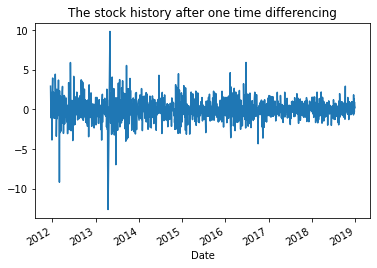

In [13]:
data['first_diff'].plot()
plt.title('The stock history after one time differencing')
plt.show()

### Deploying the Auto Regressive Integrated Moving Average (ARIMA) Model

C:\Users\veda keerthi\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


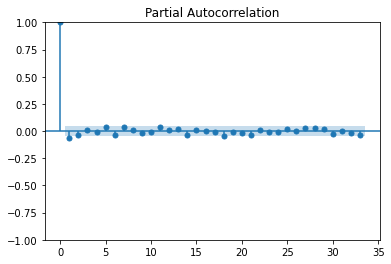

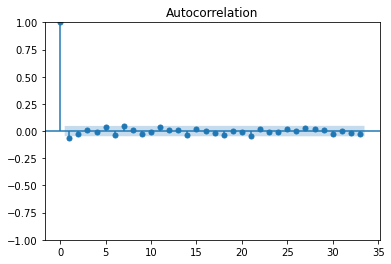

In [14]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

plot_pacf(data['first_diff'].iloc[1:])
plot_acf(data['first_diff'].iloc[1:])
plt.show()

### Fitting and Forecasting of the ARIMA Model

C:\Users\veda keerthi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\veda keerthi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


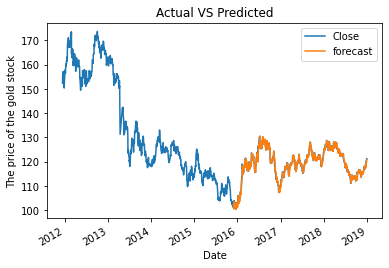

In [15]:
model=sm.tsa.statespace.SARIMAX(data['Close'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
data['forecast']=results.predict(start=950)
data[['Close','forecast']].plot()
plt.title('Actual VS Predicted')
plt.ylabel('The price of the gold stock')
plt.show()

In [16]:
data = data[['Close','forecast']]
data.dropna(inplace=True)

### Evaluation metrics for ARIMA Model

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Mean absolute error : ', mean_absolute_error(data['Close'],data['forecast']))
print('Mean squared error : ', mean_squared_error(data['Close'],data['forecast']))
print('R2 error : ', r2_score(data['Close'],data['forecast']))

Mean absolute error :  0.6914720541725479
Mean squared error :  0.8998354145042642
R2 error :  0.9753060590897782


## <center> 2. Forecasting the USO Stock Price using LSTM </center>

### Importing the data

In [39]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential

In [18]:
data = pd.read_csv('Datasets/FINAL_USO.xls',usecols=['Close'])

### Preprocessing the Data

In [19]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler(feature_range=(0,1))
scaled_data = minmax.fit_transform(data)
train_data=scaled_data[:987,:]
valid_data=scaled_data[987:,:]

### Training split

In [21]:
x_train, y_train = [], []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [22]:
x_train, y_train = np.array(x_train), np.array(y_train)

### Reshaping the training data to fit the model

In [23]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

### Model creation

In [24]:
model = Sequential([LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)),
                   LSTM(50),
                   Dense(1,activation='relu')])
model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


### Fitting the model

In [26]:
model.fit(x_train,y_train,epochs=5)

Epoch 1/5
29/29 [==============================] - 12s 28ms/step - loss: 0.0275
Epoch 2/5
29/29 [==============================] - 1s 19ms/step - loss: 0.0027
Epoch 3/5
29/29 [==============================] - 0s 16ms/step - loss: 0.0021
Epoch 4/5
29/29 [==============================] - 0s 14ms/step - loss: 0.0019
Epoch 5/5
29/29 [==============================] - 1s 18ms/step - loss: 0.0019


In [27]:
inputs_data = data[len(data)-len(valid_data)-60:].values

In [28]:
inputs_data=inputs_data.reshape(-1,1)
inputs_data=minmax.transform(inputs_data)

x_test=[]
for i in range(60,valid_data.shape[0]):
    x_test.append(scaled_data[i-60:i,0])
x_test=np.array(x_test)

C:\Users\veda keerthi\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


### Forecasting the model

In [29]:
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

closing_price=model.predict(x_test)
closing_price=minmax.inverse_transform(closing_price)

### Plotting the Actual VS Forecasted values

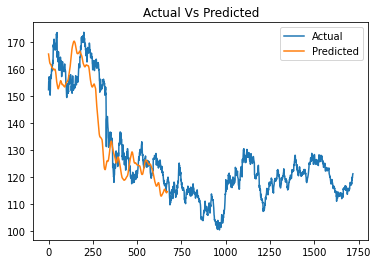

In [37]:
plt.plot(data["Close"],label='Actual')
plt.plot(closing_price,label='Predicted')
plt.title('Actual Vs Predicted')
plt.legend()
plt.show()